<center><img src="https://media.giphy.com/media/trN9ht5RlE3Dcwavg2/giphy.gif"></center>
<center><h1>💰Dinero Virtual y Elon Musk 💰</h1></center>

**En este notebook vamos a tratar de determinar si existe alguna relación entre Elon Musk y el precio del Bitcoin**
 
 Para lograrlo procederemos de la siguiente manera:
 
 * Primero vamso a extraer todos los tweest de Elon Musk entre el año 2011 hasta el año 2021. La extracción de esta información se hace mediante el API Tweepy.
 
 * Realizaremos exploración superficial de texto en sus tweets. Para lograr esta exploración debemos limpiar el texto, extraer emojis, acentos, palabras vacias entre otros procedimientos. 
 
 * Análisaremos algunas estadístiscas básicas de que Twitter nos puede proporcionar sobre Elon Musk como por ejemplo: evolución de su popularidad, las respuestas de sus tweets, reacciones...
 
 * Emplearemos un modelo LSTM que extraerá las emociones que Elon transmite a través de sus Tweets. Esta extracción se realizará por años.
 
* Finalmente, mediante mineria de texto podemos extraer las veces en las cuales Elon escribió sobre el Bitcoin y trataremos de encontrar si esto generó algún impacto en el valor de esta popular criptomoneda.



**Librerias necesarias**

Versión de Tensorflow:  2.4.1


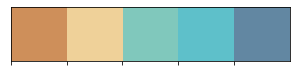

In [4]:
import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
import datetime, pytz


#librerias de visualizacion
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
import plotly
import plotly.express as px
from datetime import datetime

#####Cargando nuestro modelo de LSTM y librerias de tensor flow
from keras.models import load_model
from keras.preprocessing import text, sequence
import pickle5 as pickle



# Paleta de colores
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Configuración general de las gráficas
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.style.use('ggplot')

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'
    


# Definición de funciones globales

In [5]:
#######################Procesamiento de texto

def emoji_extractor(string, remove=False):
    '''Elimina los Emoji de un texto'''
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    if remove == False:
        # Extrae el emoji
        return emoji_pattern.findall(string)
    else:
        # quita el emoji del texto
        return emoji_pattern.sub(r'', string)

def clean_emoji(x):
    if len(x) == 0:
        return ''
    else:
        return x[0]
    
    
    
def clean_tweets(df):
    '''Retorna el dataframe limpio.'''
    
    # ----- Elimina los siguientes \n, \t, \xa0 -----
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\xa0', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ''))
    
    # ----- Elimina pic.twitter y http:// + https:// links -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
    
    # ----- Elimina menciones y hastags -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
    
    # ----- Extrae los emojis y los elimina de los twees-----
    df['tweet_emojis'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=False))
    df['tweet_emojis'].replace('', np.nan, inplace=True)
#     df["tweet_emojis"] = df["tweet_emojis"].apply(lambda x: clean_emoji(x))
    
    df['tweet'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=True))
    
    # ----- Quita los espacios en blanco -----
    df['tweet'] = df['tweet'].apply(lambda x: x.strip())
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x.split()))
    
    # ----- Elimina los simbolos de puntuación  -----
    df['tweet'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    return df




def get_sentiment(model,text):
    
   
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = sequence.pad_sequences(twt, maxlen=MAX_LEN, dtype='int32')
    sentiment = model.predict(twt)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    
    return result

def plot_result(df, string):
    
    colors={'joy':'rgb(213,0,0)','sadness':'rgb(0,0,0)',
                    'anger':'rgb(0,142,248)','fear':'rgb(245,178,123)',
                    'love':'rgb(237,236,236)','surprise':'rgb(216,74,9)'}
    col_2={}
    for i in df.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df, values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3)
    fig.show(renderer = 'notebook_connected')
    plotly.offline.plot(fig, filename = 'modelo_tweets'+string+'.html', auto_open=False)



# 📥 Importando los datos

Bitcoin shape: (4857377, 8) 
Dogecoin shape: (2501, 7)


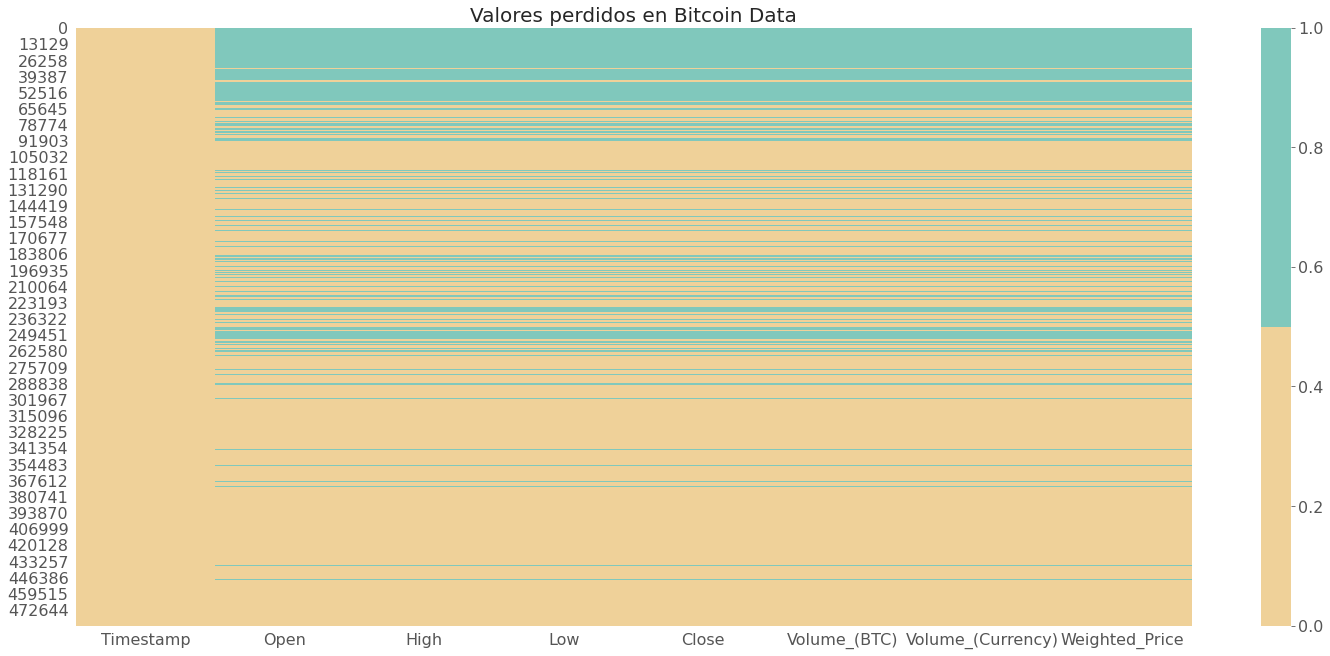

In [7]:
# === Tweets ===
tweets = pd.read_csv("../input/tweets-proyecto-series/TweetsElonMusk.csv")
tweets = tweets[["id", "date", "time", "username", 
                 "tweet", "mentions", "urls", "photos", "replies_count", 
                 "retweets_count", "likes_count", "hashtags", "link"]]

tweets["year"] = tweets["date"].apply(lambda x: x.split("-")[0])


# Clean Tweets
tweets = clean_tweets(df=tweets)

# === Bitcoin ===

bitcoin = pd.read_csv("../input/data-para-el-proyecto/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=[0], date_parser=dateparse)



# Dimensiones de los datasets

print(color.BOLD + "Bitcoin shape:" + color.END, "{}".format(bitcoin.shape))


#Investigación superficial de los valores perdidos en cada dataset Bitcoin!

plt.figure(figsize = (25, 11))
sns.heatmap(bitcoin.isna().as_matrix()[::10], cmap = [my_colors[1], 
                                                      my_colors[2]], xticklabels=bitcoin.columns)
plt.title("Valores perdidos en Bitcoin Data", size=20);



**Visualización de los datasets**

In [8]:
#Eliminamos todos los registros que contengan informaciòn nula
bitcoin.dropna(axis=0, inplace=True)
###########3
print("Dimensión luego de eliminar los datos nulos:", bitcoin.shape)
bitcoin.head(1)

Dimensión luego de eliminar los datos nulos: (3613769, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [10]:
tweets.head(2)

,id,date,time,username,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,link,year,tweet_emojis
0,1381273474400800773,2021-04-11,18:50:33,elonmusk,for now costs are decreasing rapidly,[],[],[],640,444,15281,[],https://twitter.com/elonmusk/status/1381273474...,2021,[]
1,1381273076709478403,2021-04-11,18:48:58,elonmusk,love this beautiful shot,[],[],[],2464,1517,71161,[],https://twitter.com/elonmusk/status/1381273076...,2021,[]


#  🎇 Análisis de los Tweets de Elon Musk

In [ ]:
run = wandb.init(project='Bitcoin', name='analisis_elonmusk')

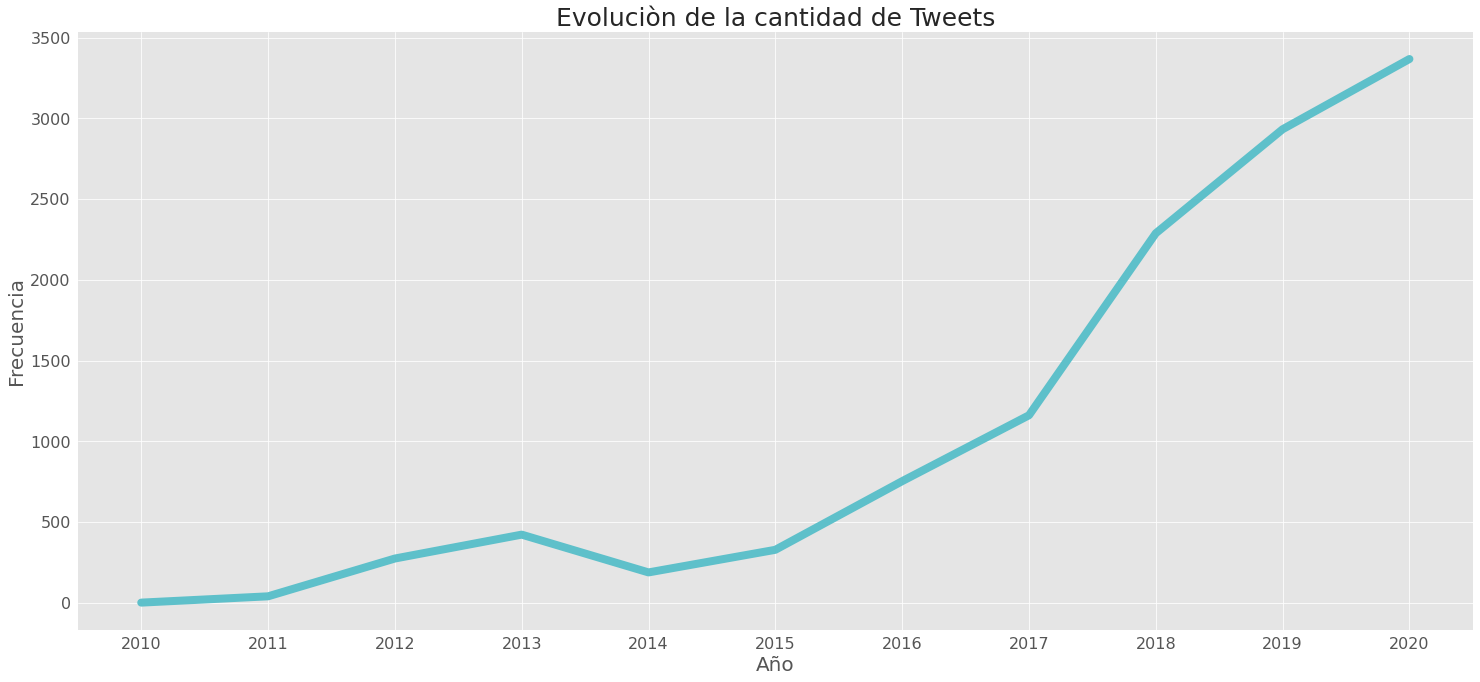

In [549]:
# Evolucion del tiempo
date_count_df = tweets[tweets["year"]!="2021"].groupby("year")["tweet"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.lineplot(data=date_count_df, x="year", y="tweet", lw=8, color=my_colors[3])
plt.title("Evoluciòn de la cantidad de Tweets", size=25)
plt.xlabel("Año", size=20)
plt.ylabel("Frecuencia", size=20)
sns.despine(left=True)

📝**Análisis de su popularidad**

 > Parece que su popularidad ha aumentado en los últimos años. Aumentó gradualmente en likes con el pico en 2020 (y apuesto a que continuará en 2021 también), pero las respuestas alcanzaron un pico también (se está comunicando más con una audiencia más amplia.

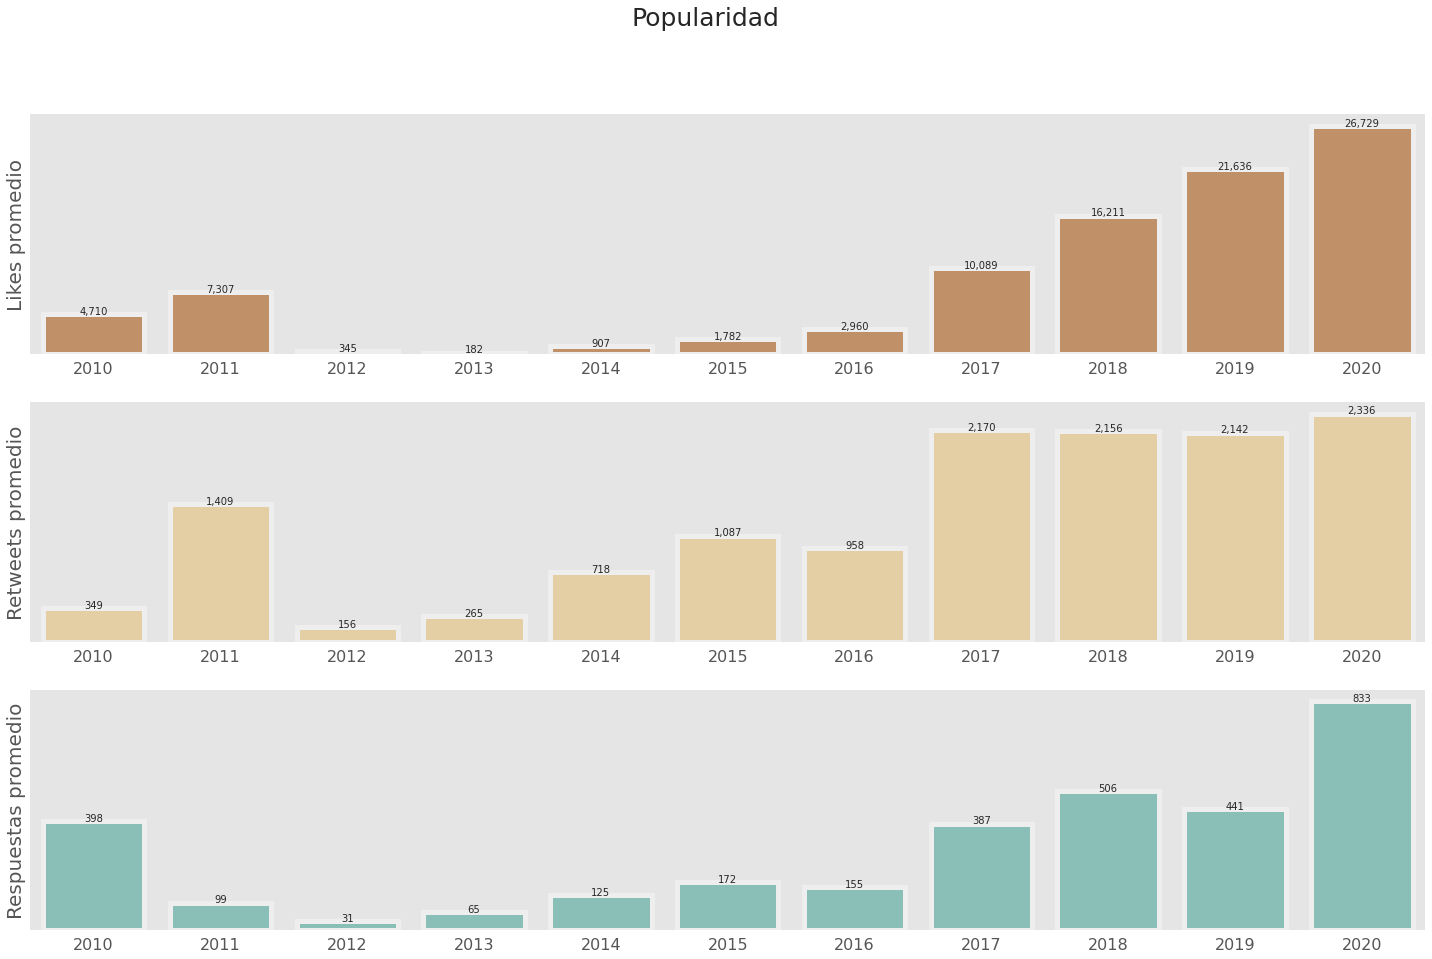

In [550]:
# Información de la popularidad
popularity = ["likes_count", "retweets_count", "replies_count"]
popularity_df = tweets[tweets["year"]!="2021"].groupby("year").agg({popularity[0] : 'sum',
                                                                    popularity[1] : 'sum',
                                                                    popularity[2] : 'sum',
                                                                    'tweet' : 'count'}).reset_index()
popularity_df["likes_count"] = popularity_df["likes_count"]/popularity_df["tweet"]
popularity_df["retweets_count"] = popularity_df["retweets_count"]/popularity_df["tweet"]
popularity_df["replies_count"] = popularity_df["replies_count"]/popularity_df["tweet"]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15))
axs = [ax1, ax2, ax3]
plt.suptitle("Popularidad", size=25)
sns.barplot(data=popularity_df, x="year", y="likes_count", lw=5, color=my_colors[0], ax=ax1)
sns.barplot(data=popularity_df, x="year", y="retweets_count", lw=5, color=my_colors[1], ax=ax2)
sns.barplot(data=popularity_df, x="year", y="replies_count", lw=5, color=my_colors[2], ax=ax3)
names = ["Likes promedio", "Retweets promedio", "Respuestas promedio"]
for ax, n in zip(axs, names):
    ax.set_xlabel("", size=20)
    ax.set_ylabel(n, size=20)
    ax.get_yaxis().set_ticks([])
#     ax.title.set_text(n)
    show_values_on_bars(axs=ax, h_v="v", space=0.4)
sns.despine(left=True);

In [ ]:
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["likes_count"], 
                     x_name="Año", y_name="Likes", 
                     title="Evolición de los Likes ", log="likes_evolucio")
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["retweets_count"], 
                     x_name="Año", y_name="Retweets", 
                     title="Evolución de Retweets", log="retweets_evolucion")
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["replies_count"], 
                     x_name="Año", y_name="Respuestas", 
                     title="Evolución de respesta", log="respuesta_evolucion")

📝  **Palabras más frecuentes en sus Tweets**

> Las palabras más frecuentes son: Tesla, cohete, Marte, nave estelar, lanzamiento. Se observa que la redacción suena súper positiva: sí, sí, bien, gracias, gente, claro. Eso me gusta mucho. Siempre es super positivo y entusiasta en sus mensajes.

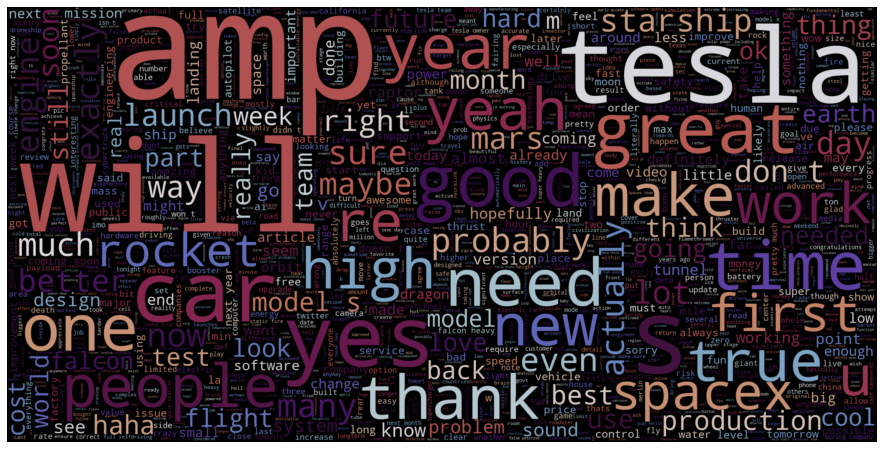

In [551]:
all_tweets = " ".join(token for token in tweets["tweet"])
stopwords_wc = set(stopwords_wc)


wordcloud = WordCloud(stopwords=stopwords_wc,
                      max_words=1500,
                      max_font_size=350, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

🔎 **Análisis de Bitcoin y Dogecoin en sus Tweets**

In [552]:
# Solo trae información de Bitcoin 
bitcoin_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
dogecoin_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)

# Información
print(color.BOLD + "% de Tweets sobre Bitcoin:" + color.END, "{:.3}%".format(bitcoin_tweets.shape[0]/tweets.shape[0]*100), "\n" +
      color.BOLD + "% de Tweets sobre Dogecoin:" + color.END, "{:.3}%".format(dogecoin_tweets.shape[0]/tweets.shape[0]*100))

top = bitcoin_tweets.sort_values("likes_count", ascending=False)[:7]["tweet"]
print("\n", color.BOLD + "Los Tweets con más likes sobre BITCOIN:" + color.END)
for k, text in enumerate(top):
    print(f"{k+1}. {text}")
    
top = dogecoin_tweets.sort_values("likes_count", ascending=False)[:7]["tweet"]
print("\n", color.BOLD + "Los Tweets con más likes sobre  DOGECOIN:" + color.END)
for k, text in enumerate(top):
    print(f"{k+1}. {text}")

% de Tweets sobre Bitcoin: 0.111% 
% de Tweets sobre Dogecoin: 0.0796%

 Los Tweets con más likes sobre BITCOIN:
1. you can now buy a tesla with bitcoin
2. btc bitcoin is an anagram of tbcthe boring company what a coincidence
3. bitcoin is my safe word
4. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
5. pay by bitcoin capability available outside us later this year
6. bitcoin is almost as bs as fiat money
7. bitcoin is not my safe word

 Los Tweets con más likes sobre  DOGECOIN:
1. dogecoin is the people’s crypto
2. bought some dogecoin for lil x so he can be a toddler hodler
3. spacex is going to put a literal dogecoin on the literal moon
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. dogecoin rulz
6. origin of doge day afternoon the ancient romans sacrificed a dogecoin at th

**😎 Análisis de emociones en sus Tweets**

In [ ]:
run = wandb.init(project='Bitcoin', name='analisis_elonmusk_emociones')

 > Para realizar el análisis de emociones en sus Tweets vamos a partir nuestro conjunto de datos de la siguiente manera:
>  * Tweest desde el 2010-2014
>  * Tweets desde el 2014-2018
>  * Tweets desde el 2018-2021
 

In [553]:
model_emociones = load_model('../input/modelo-emociones/model_emociones_copy.h5')
model_emociones

In [554]:
with open("../input/tokenizer-keras/tokenize.pickle", 'rb') as handle:
    token = pickle.load(handle)

token

In [555]:
tweets.head(1)

,id,date,time,username,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,link,year,tweet_emojis
0,1381273474400800773,2021-04-11,18:50:33,elonmusk,for now costs are decreasing rapidly,[],[],[],640,444,15281,[],https://twitter.com/elonmusk/status/1381273474...,2021,[]


In [556]:
tweets.year = tweets.year.astype(int)
tweets_2010_2014 = tweets[(tweets.year >=2010) & (tweets.year<2014)]
tweets_2014_2018 = tweets[(tweets.year >=2014) & (tweets.year<2018)]
tweets_2018_2021 = tweets[(tweets.year >=2018) & (tweets.year<=2021)]

**Resultados para los Tweets entre el 2010 y 2014**

In [557]:
MAX_LEN = 32 #Máxima longitud de la secuencia
sent_to_id = {'anger': 0, 'love': 1, 'fear': 2, 'joy': 3, 'sadness': 4,'surprise': 5}

In [558]:
texts=tweets_2010_2014.tweet.tolist()
texts=' '.join(texts)
result =get_sentiment(model_emociones,texts)
plot_result(result, '2010_2014_')

**Resultados para los Tweets entre el 2014 y 2018**

In [559]:
texts=tweets_2014_2018.tweet.tolist()
texts=' '.join(texts)
result =get_sentiment(model_emociones,texts)
plot_result(result, '2014_2018_')

**Resultados 2018- 20221**

In [560]:
texts=tweets_2018_2021.tweet.tolist()
texts=' '.join(texts)
result =get_sentiment(model_emociones,texts)
plot_result(result, '2018_2021_')

* **Podemos observar que los Tweets de Elon entre los años del 2010 al 2014 eran bastante homogeneos en su contenido ya que el 98% de ellos son tweets con emociones positivas y de disfrute.**

* **También podemos observar que en el 2014 hasta el 2018 el contenido de sus tweets es más variado debido a las emociones detectadas en ellos, se observa que en este periodo muchos de sus tweets expresan tristeza 47%, enojo 12% y 7% de miedo. Quizá estos altos porcentajes se deban principalmente al fracaso de SpaceX.**

* **Notemos que el sentimiento de disfrute aumentó considerablemente en los últimos tres años y el sentimiento de tristeza disminuyó hasta el 39%**.

# 🖇¿Hay alguna correlación entre el precio del Bitcoin y Elon Musk?

In [561]:
data = bitcoin[['Timestamp', 'Weighted_Price']]
############################################## Damos formato correcto a la fecha para 
#### analizar la estacionalidad

data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data['Weighted_Price'].fillna(method='ffill', inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



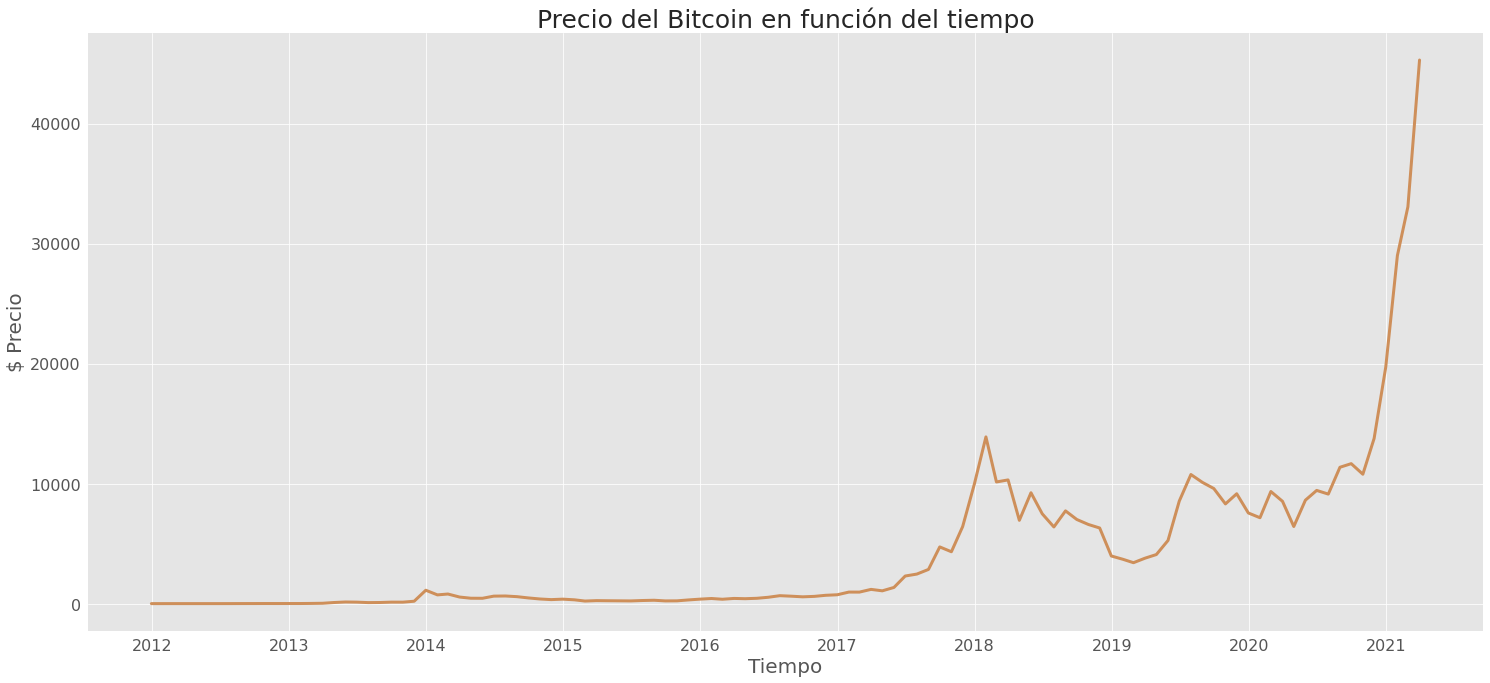

In [12]:
plt.figure(figsize = (25, 11))
plt.plot(data.index, data["Weighted_Price"], color=my_colors[0], lw=3)
plt.title("Precio del Bitcoin en función del tiempo", size=25)
plt.xlabel("Tiempo", size=20)
plt.ylabel("$ Precio", size=20)
plt.savefig("Bitcoin_plot.png", bbox_inches='tight');

Para ello, he decidido analizar los momentos en los que Elon tuiteó sobre Bitcoin.

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin
4. btc bitcoin is an anagram of tbcthe boring company what a coincidence
5. to be clear i am not an investor i am an engineer i don’t even own any publicly traded stock besides tesla however when fiat currency has negative real interest only a fool wouldn’t look elsewhere bitcoin is almost as bs as fiat money the key word is “almost”
6. tesla’s action is not directly reflective of my opinion having some bitcoin which is simply a less dumb form of liquidity than cash is adventurous enough for an sampp500 company
7. bitcoin is almost as bs as fiat money
8. bitcoin is my safe word
9. toss a bitcoin to ur witcher
10. i still only own 025 bitcoins btw
11. pretty much although massive currency issuance by govt centra

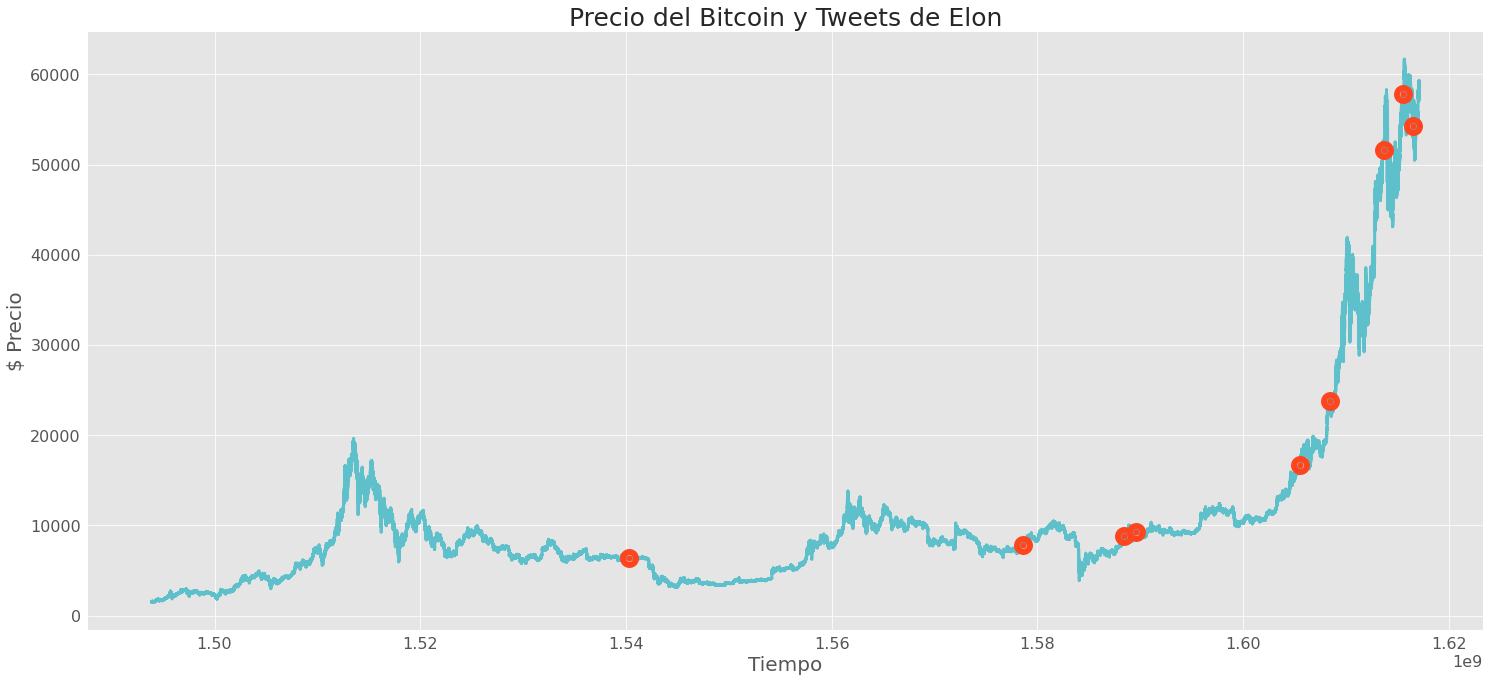

In [9]:
# Tweets sobre Bitcoin
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
# Convertir fecha a  nùmero
btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
# Sólo los últimos datos de bitcoin (como Elon nunca tuiteó antes de 2018)
btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(2000000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Obtener la intersección
x_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"])
y_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"])

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_array(), btc_prices["Weighted_Price"].to_array(), color=my_colors[3], lw=3, zorder=1)
plt.title("Precio del Bitcoin y Tweets de Elon", size=25)
plt.xlabel("Tiempo", size=20)
plt.ylabel("$ Precio", size=20)
plt.savefig("bitcoin_elon.png",  bbox_inches='tight');    


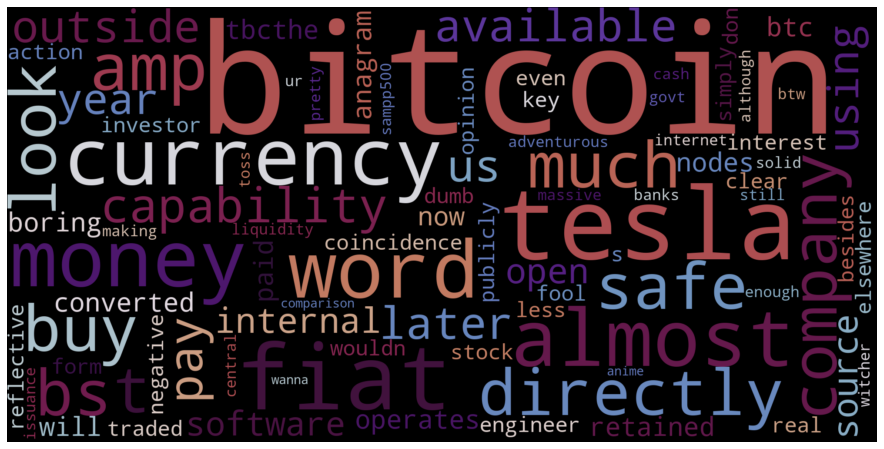

In [10]:
all_tweets = " ".join(token for token in btc_tweets["tweet"])
stopwords_wc = set(stopwords_wc)


wordcloud = WordCloud(stopwords=stopwords_wc,
                      max_words=1500,
                      max_font_size=350, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

**Ampliando un poco más la información**

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin


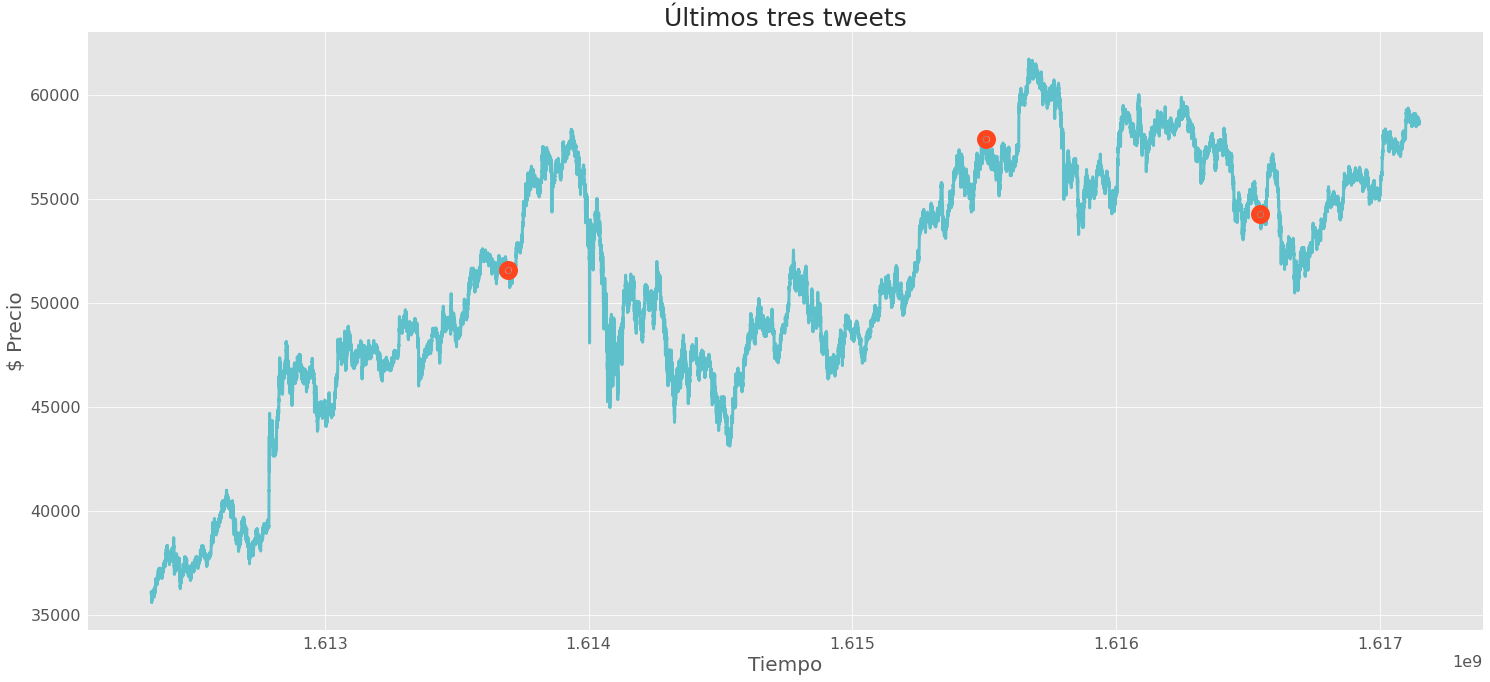

In [12]:
#Obtener la información de Bitcoin
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)

btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())

btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(80000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"][:3]): print(color.BOLD + f"{k+1}." + color.END, tweet)

x_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"])
y_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"])

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_array(), btc_prices["Weighted_Price"].to_array(), color=my_colors[3], lw=3, zorder=1)
plt.title("Últimos tres tweets", size=25)
plt.xlabel("Tiempo", size=20)
plt.ylabel("$ Precio", size=20)
plt.savefig("ultimos_bitcoin_elon.png",  bbox_inches='tight');    

* La actividad de Elon en los años 2010-2014, en twiter fue bastante reducida. Adicionalmente, se observa que el contenido de los tweets durante esta época es bastante simple ya que nuestro modelo de LSTM no detecto muchas emociones en ellos.


* Se pueden observar algunos picos en el precio del Bitcoin, luego de los Tweets de Elon. Sin embargo, no podemos asegurar que existe una relación clara entre el precio del Bitcoin y el contenido de los tweets de Elon Musk.


* Podemos observar que la cantidad de Tweets de Elon viene aumentando en los últimos años al igual que el precio del Bitcoin quizá existe alguna similitud? Podemos dejar como ejercicio realizar un prónostico del comportamiento de Elon en Twitter para el siguiente año y ver si este comportamiento se asemeja al precio del Bitcoin!!


